# Cancer Mortality Prediction with Model Monitoring**A Machine Learning Project for Predicting County-Level Cancer Mortality Rates**---## Project OverviewThis notebook implements a comprehensive machine learning pipeline for predicting cancer mortality rates (TARGET_deathRate) with advanced model monitoring using Evidently AI.### Workflow:1. **Data Loading & Preprocessing** - Clean and prepare the dataset2. **Model Training** - Train a Gradient Boosting Regressor3. **Baseline Evaluation** - Assess performance on test set4. **Scenario Testing** - Test model robustness under data drift:   - Scenario A: Economic decline (decrease median income by $40,000)   - Scenario AB: Economic decline + Increased poverty (+20 percentage points)   - Scenario ABC: Multi-factor drift (AB + Increased household size +2)5. **Model Monitoring** - Generate Evidently AI drift detection reports

## 1. Setup and Imports

In [1]:
# Standard libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import os
from datetime import datetime
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model Monitoring
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, RegressionPreset
from evidently.metrics import (
    DatasetDriftMetric,
    DatasetMissingValuesMetric,
    ColumnDriftMetric,
    RegressionQualityMetric,
    RegressionPredictedVsActualScatter,
    RegressionErrorDistribution
)

print("✓ All libraries imported successfully!")
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ All libraries imported successfully!
Execution started at: 2025-11-18 15:36:58


## 2. Data Loading and Preprocessing

In [2]:
class CancerDataLoader:
    """Handles data loading, preprocessing, and feature engineering."""
    
    def __init__(self, data_path='data/cancer_reg.csv', test_size=0.2, random_state=42):
        """
        Initialize data loader.
        
        Args:
            data_path: Path to the cancer dataset CSV file
            test_size: Proportion of data to use for testing
            random_state: Random seed for reproducibility
        """
        self.data_path = data_path
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.feature_columns = None
        self.target_column = 'TARGET_deathRate'
        
    def load_data(self):
        """Load the cancer dataset from CSV."""
        print(f"Loading data from {self.data_path}...")
        # Try different encodings to handle various CSV formats
        try:
            df = pd.read_csv(self.data_path)
        except UnicodeDecodeError:
            print("  UTF-8 encoding failed, trying latin-1...")
            df = pd.read_csv(self.data_path, encoding='latin-1')
        print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
        return df
    
    def preprocess_data(self, df):
        """
        Preprocess the dataset: handle missing values, select features.
        
        Args:
            df: Raw dataframe
            
        Returns:
            Preprocessed dataframe
        """
        print("\nPreprocessing data...")
        
        # Create a copy to avoid modifying original
        df_processed = df.copy()
        
        # Drop non-numeric columns that aren't useful for modeling
        columns_to_drop = ['Geography', 'binnedInc']
        df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')
        
        # Handle missing values
        print(f"Missing values before imputation: {df_processed.isnull().sum().sum()}")
        
        # Fill numeric columns with median
        numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_processed[col].isnull().any():
                df_processed[col].fillna(df_processed[col].median(), inplace=True)
        
        print(f"Missing values after imputation: {df_processed.isnull().sum().sum()}")
        
        # Ensure target column exists
        if self.target_column not in df_processed.columns:
            raise ValueError(f"Target column '{self.target_column}' not found in dataset")
        
        return df_processed
    
    def split_data(self, df):
        """
        Split data into training and testing sets.
        
        Args:
            df: Preprocessed dataframe
            
        Returns:
            X_train, X_test, y_train, y_test, feature_columns
        """
        print("\nSplitting data into train and test sets...")
        
        # Separate features and target
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        
        # Store feature columns
        self.feature_columns = X.columns.tolist()
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )
        
        print(f"Training set: {len(X_train)} samples")
        print(f"Test set: {len(X_test)} samples")
        print(f"Number of features: {len(X_train.columns)}")
        
        return X_train, X_test, y_train, y_test, self.feature_columns
    
    def scale_features(self, X_train, X_test):
        """
        Scale features using StandardScaler.
        
        Args:
            X_train: Training features
            X_test: Test features
            
        Returns:
            X_train_scaled, X_test_scaled
        """
        print("\nScaling features...")
        
        # Fit scaler on training data only
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Convert back to DataFrame to preserve column names
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
        
        return X_train_scaled, X_test_scaled
    
    def prepare_data(self):
        """
        Complete data preparation pipeline.
        
        Returns:
            Dictionary containing all prepared data
        """
        # Load data
        df = self.load_data()
        
        # Preprocess
        df_processed = self.preprocess_data(df)
        
        # Split data
        X_train, X_test, y_train, y_test, feature_columns = self.split_data(df_processed)
        
        # Scale features
        X_train_scaled, X_test_scaled = self.scale_features(X_train, X_test)
        
        # Return all data components
        return {
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test,
            'feature_columns': feature_columns,
            'scaler': self.scaler,
            'X_test_unscaled': X_test  # Keep unscaled version for monitoring
        }

print("✓ CancerDataLoader class defined")

✓ CancerDataLoader class defined


In [3]:
# Load and prepare data
print("="*80)
print("STEP 1: DATA PREPARATION")
print("="*80)

loader = CancerDataLoader(data_path='data/cancer_reg.csv', test_size=0.2, random_state=42)
data = loader.prepare_data()

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
feature_columns = data['feature_columns']
scaler = data['scaler']
X_test_unscaled = data['X_test_unscaled']

print(f"\n✓ Data preparation complete!")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Number of features: {len(feature_columns)}")

STEP 1: DATA PREPARATION
Loading data from data/cancer_reg.csv...
  UTF-8 encoding failed, trying latin-1...
Data loaded: 3047 rows, 34 columns

Preprocessing data...
Missing values before imputation: 3046
Missing values after imputation: 0

Splitting data into train and test sets...
Training set: 2437 samples
Test set: 610 samples
Number of features: 31

Scaling features...

✓ Data preparation complete!
  Training samples: 2437
  Test samples: 610
  Number of features: 31


In [4]:
# Display first few rows of training data
print("\nTraining Data Sample:")
display(X_train.head())

print("\nTarget Variable Statistics:")
print(y_train.describe())


Training Data Sample:


,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
2830,-0.376021,-0.312820,-0.802272,0.023753,-0.271636,-0.478875,-0.291095,-0.103303,0.039439,0.100981,...,0.896297,0.593498,-0.600401,-1.032989,0.528427,-0.481200,-0.245521,-0.316621,-0.052465,0.348384
1188,-0.438878,-0.378548,-1.744703,2.545803,-0.315782,-1.581173,-0.291095,-0.161168,-0.510313,-0.442143,...,1.890191,1.388256,-2.342928,-1.767273,0.735201,-0.627518,-0.278717,-0.530352,2.026998,-0.245397
887,-0.267379,-0.183556,-0.332875,2.835350,-0.181290,-1.470943,-0.291095,-0.045439,0.589190,0.363180,...,1.756183,1.526014,-0.964511,-0.949547,0.364684,-0.112104,-0.144619,-0.437048,1.692071,-0.004508
1924,-0.406285,-0.332538,-0.734955,-0.358368,-0.273177,-0.352898,-0.291095,-0.311187,-1.780428,-1.977875,...,0.248591,0.561708,-1.224590,-0.181887,-0.245534,-0.422345,2.801363,1.020523,1.793340,2.412272
2921,-0.379125,-0.284338,1.000720,-0.013074,-0.300514,-0.431634,-0.291095,-0.024007,0.721888,0.606649,...,-0.119931,0.137836,0.804024,0.652528,0.886513,-0.599616,-0.336974,-0.559800,0.436037,-0.812808



Target Variable Statistics:
count    2437.000000
mean      178.608535
std        27.533371
min        59.700000
25%       161.700000
50%       178.600000
75%       195.100000
max       362.800000
Name: TARGET_deathRate, dtype: float64


## 3. Model Training

In [5]:
class CancerMortalityModel:
    """Handles model training, evaluation, and prediction."""
    
    def __init__(self, model_type='gradient_boosting', random_state=42):
        """
        Initialize the model.
        
        Args:
            model_type: Type of model to use ('gradient_boosting', 'random_forest', 'ridge')
            random_state: Random seed for reproducibility
        """
        self.model_type = model_type
        self.random_state = random_state
        self.model = None
        self.training_metrics = {}
        self.test_metrics = {}
        
        # Initialize model based on type
        self._initialize_model()
    
    def _initialize_model(self):
        """Initialize the ML model based on model_type."""
        if self.model_type == 'gradient_boosting':
            self.model = GradientBoostingRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=self.random_state,
                verbose=0
            )
        elif self.model_type == 'random_forest':
            self.model = RandomForestRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=self.random_state,
                n_jobs=-1,
                verbose=0
            )
        elif self.model_type == 'ridge':
            self.model = Ridge(
                alpha=1.0,
                random_state=self.random_state
            )
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")
    
    def train(self, X_train, y_train):
        """
        Train the model.
        
        Args:
            X_train: Training features
            y_train: Training target
        """
        print(f"\nTraining {self.model_type} model...")
        self.model.fit(X_train, y_train)
        
        # Calculate training metrics
        y_train_pred = self.model.predict(X_train)
        self.training_metrics = self._calculate_metrics(y_train, y_train_pred, "Training")
        
        print(f"Training complete!")
        
        return self
    
    def evaluate(self, X_test, y_test, dataset_name="Test"):
        """
        Evaluate the model on test data.
        
        Args:
            X_test: Test features
            y_test: Test target
            dataset_name: Name of the dataset for display
            
        Returns:
            Dictionary of metrics
        """
        print(f"\nEvaluating model on {dataset_name} data...")
        y_pred = self.model.predict(X_test)
        
        metrics = self._calculate_metrics(y_test, y_pred, dataset_name)
        
        if dataset_name == "Test":
            self.test_metrics = metrics
        
        return metrics
    
    def _calculate_metrics(self, y_true, y_pred, dataset_name):
        """
        Calculate and display regression metrics.
        
        Args:
            y_true: True target values
            y_pred: Predicted target values
            dataset_name: Name of the dataset for display
            
        Returns:
            Dictionary of metrics
        """
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
        
        print(f"\n{dataset_name} Metrics:")
        print(f"  RMSE:  {rmse:.4f}")
        print(f"  MAE:   {mae:.4f}")
        print(f"  R²:    {r2:.4f}")
        print(f"  MAPE:  {mape:.2f}%")
        
        return metrics
    
    def predict(self, X):
        """
        Make predictions.
        
        Args:
            X: Features to predict on
            
        Returns:
            Predictions array
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet")
        
        return self.model.predict(X)
    
    def save_model(self, filepath='models/cancer_model.pkl'):
        """
        Save the trained model to disk.
        
        Args:
            filepath: Path to save the model
        """
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
        
        print(f"\nModel saved to {filepath}")
    
    @staticmethod
    def load_model(filepath='models/cancer_model.pkl'):
        """
        Load a trained model from disk.
        
        Args:
            filepath: Path to the saved model
            
        Returns:
            Loaded model instance
        """
        with open(filepath, 'rb') as f:
            model = pickle.load(f)
        
        print(f"Model loaded from {filepath}")
        return model
    
    def get_feature_importance(self, feature_names, top_n=20):
        """
        Get feature importance for tree-based models.
        
        Args:
            feature_names: List of feature names
            top_n: Number of top features to return
            
        Returns:
            DataFrame with feature importance
        """
        if self.model_type in ['gradient_boosting', 'random_forest']:
            importance = self.model.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)
            
            print(f"\nTop {top_n} Most Important Features:")
            print("="*60)
            for idx, row in feature_importance.head(top_n).iterrows():
                print(f"{row['feature']:30s} {row['importance']:.6f}")
            
            return feature_importance
        else:
            print(f"Feature importance not available for {self.model_type}")
            return None
    
    def compare_predictions(self, y_true, y_pred, num_samples=10):
        """
        Display comparison of actual vs predicted values.
        
        Args:
            y_true: True target values
            y_pred: Predicted target values
            num_samples: Number of samples to display
        """
        comparison = pd.DataFrame({
            'Actual': y_true.values[:num_samples] if isinstance(y_true, pd.Series) else y_true[:num_samples],
            'Predicted': y_pred[:num_samples],
            'Difference': np.abs(y_true.values[:num_samples] - y_pred[:num_samples]) if isinstance(y_true, pd.Series) else np.abs(y_true[:num_samples] - y_pred[:num_samples])
        })
        
        print(f"\nSample Predictions (first {num_samples}):")
        print("="*60)
        print(comparison.to_string(index=False))
        print("="*60)

print("✓ CancerMortalityModel class defined")

✓ CancerMortalityModel class defined


In [6]:
# Train the model
print("="*80)
print("STEP 2: MODEL TRAINING")
print("="*80)

model = CancerMortalityModel(random_state=42)
model.train(X_train, y_train)

# Get training predictions for reference data
y_train_pred = model.predict(X_train)

# Show feature importance
feature_importance = model.get_feature_importance(feature_columns, top_n=15)

# Save model
model.save_model('models/cancer_model.pkl')

STEP 2: MODEL TRAINING

Training gradient_boosting model...

Training Metrics:
  RMSE:  4.2224
  MAE:   3.3122
  R²:    0.9765
  MAPE:  1.89%
Training complete!

Top 15 Most Important Features:
incidenceRate                  0.207390
PctBachDeg25_Over              0.207243
avgDeathsPerYear               0.069493
popEst2015                     0.051956
PctHS25_Over                   0.049069
avgAnnCount                    0.042308
medIncome                      0.034134
povertyPercent                 0.028470
PctOtherRace                   0.027830
PctPublicCoverageAlone         0.026612
PctPrivateCoverage             0.022457
PctHS18_24                     0.022332
PctMarriedHouseholds           0.022222
PctBlack                       0.020045
PctWhite                       0.015287

Model saved to models/cancer_model.pkl


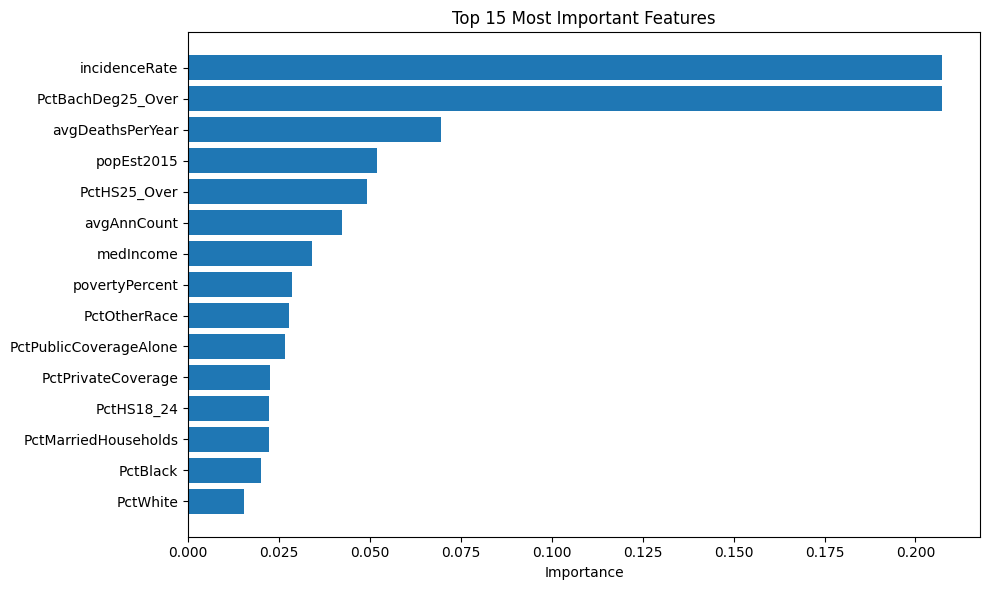

In [7]:
# Visualize top features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. Model Monitoring Setup

In [8]:
class ModelMonitor:
    """Handles model monitoring with Evidently AI."""
    
    def __init__(self, feature_columns, target_column='TARGET_deathRate', prediction_column='prediction'):
        """
        Initialize the monitoring system.
        
        Args:
            feature_columns: List of feature column names
            target_column: Name of the target column
            prediction_column: Name of the prediction column
        """
        self.feature_columns = feature_columns
        self.target_column = target_column
        self.prediction_column = prediction_column
        
        # Set up column mapping for Evidently
        self.column_mapping = ColumnMapping(
            target=target_column,
            prediction=prediction_column,
            numerical_features=feature_columns
        )
        
        # Create reports directory
        self.reports_dir = 'evidently_reports'
        os.makedirs(self.reports_dir, exist_ok=True)
    
    def prepare_reference_data(self, X_train, y_train, y_train_pred):
        """
        Prepare reference dataset (baseline) for comparison.
        
        Args:
            X_train: Training features
            y_train: Training target
            y_train_pred: Training predictions
            
        Returns:
            Reference DataFrame
        """
        # Create reference dataframe
        if isinstance(X_train, pd.DataFrame):
            reference_df = X_train.copy()
        else:
            reference_df = pd.DataFrame(X_train, columns=self.feature_columns)
        
        reference_df[self.target_column] = y_train.values if isinstance(y_train, pd.Series) else y_train
        reference_df[self.prediction_column] = y_train_pred
        
        return reference_df
    
    def prepare_current_data(self, X_test, y_test, y_test_pred):
        """
        Prepare current dataset for comparison.
        
        Args:
            X_test: Test features
            y_test: Test target
            y_test_pred: Test predictions
            
        Returns:
            Current DataFrame
        """
        # Create current dataframe
        if isinstance(X_test, pd.DataFrame):
            current_df = X_test.copy()
        else:
            current_df = pd.DataFrame(X_test, columns=self.feature_columns)
        
        current_df[self.target_column] = y_test.values if isinstance(y_test, pd.Series) else y_test
        current_df[self.prediction_column] = y_test_pred
        
        return current_df
    
    def generate_data_drift_report(self, reference_data, current_data, scenario_name="baseline"):
        """
        Generate data drift report using Evidently.
        
        Args:
            reference_data: Reference (baseline) dataset
            current_data: Current dataset to compare
            scenario_name: Name of the scenario for report naming
            
        Returns:
            Path to the saved report
        """
        print(f"\nGenerating Data Drift Report for {scenario_name}...")
        
        # Create report with data drift preset
        report = Report(metrics=[
            DataDriftPreset(),
            DatasetDriftMetric(),
            DatasetMissingValuesMetric()
        ])
        
        # Run the report
        report.run(
            reference_data=reference_data,
            current_data=current_data,
            column_mapping=self.column_mapping
        )
        
        # Save report
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_path = os.path.join(
            self.reports_dir, 
            f'data_drift_report_{scenario_name}_{timestamp}.html'
        )
        report.save_html(report_path)
        
        print(f"Data Drift Report saved to: {report_path}")
        
        return report_path
    
    def generate_model_performance_report(self, reference_data, current_data, scenario_name="baseline"):
        """
        Generate model performance report using Evidently.
        
        Args:
            reference_data: Reference (baseline) dataset
            current_data: Current dataset to compare
            scenario_name: Name of the scenario for report naming
            
        Returns:
            Path to the saved report
        """
        print(f"\nGenerating Model Performance Report for {scenario_name}...")
        
        # Create report with regression preset
        report = Report(metrics=[
            RegressionPreset(),
            RegressionQualityMetric(),
            RegressionPredictedVsActualScatter(),
            RegressionErrorDistribution()
        ])
        
        # Run the report
        report.run(
            reference_data=reference_data,
            current_data=current_data,
            column_mapping=self.column_mapping
        )
        
        # Save report
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_path = os.path.join(
            self.reports_dir,
            f'model_performance_report_{scenario_name}_{timestamp}.html'
        )
        report.save_html(report_path)
        
        print(f"Model Performance Report saved to: {report_path}")
        
        return report_path
    
    def generate_feature_drift_report(self, reference_data, current_data, 
                                     monitored_features, scenario_name="baseline"):
        """
        Generate detailed feature drift report for specific features.
        
        Args:
            reference_data: Reference (baseline) dataset
            current_data: Current dataset to compare
            monitored_features: List of features to monitor closely
            scenario_name: Name of the scenario for report naming
            
        Returns:
            Path to the saved report
        """
        print(f"\nGenerating Feature Drift Report for {scenario_name}...")
        
        # Create metrics for each monitored feature
        feature_metrics = [ColumnDriftMetric(column_name=feature) for feature in monitored_features]
        
        # Create report
        report = Report(metrics=[
            DatasetDriftMetric(),
            *feature_metrics
        ])
        
        # Run the report
        report.run(
            reference_data=reference_data,
            current_data=current_data,
            column_mapping=self.column_mapping
        )
        
        # Save report
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_path = os.path.join(
            self.reports_dir,
            f'feature_drift_report_{scenario_name}_{timestamp}.html'
        )
        report.save_html(report_path)
        
        print(f"Feature Drift Report saved to: {report_path}")
        
        return report_path
    
    def generate_comprehensive_report(self, reference_data, current_data, 
                                     monitored_features=None, scenario_name="baseline"):
        """
        Generate comprehensive monitoring report including all aspects.
        
        Args:
            reference_data: Reference (baseline) dataset
            current_data: Current dataset to compare
            monitored_features: Optional list of features to monitor closely
            scenario_name: Name of the scenario for report naming
            
        Returns:
            Dictionary with paths to all generated reports
        """
        print(f"\n{'='*60}")
        print(f"GENERATING COMPREHENSIVE MONITORING REPORTS - {scenario_name.upper()}")
        print(f"{'='*60}")
        
        # Generate all reports
        drift_report = self.generate_data_drift_report(reference_data, current_data, scenario_name)
        performance_report = self.generate_model_performance_report(reference_data, current_data, scenario_name)
        
        reports = {
            'data_drift': drift_report,
            'model_performance': performance_report
        }
        
        # Generate feature drift report if specific features are provided
        if monitored_features:
            feature_report = self.generate_feature_drift_report(
                reference_data, current_data, monitored_features, scenario_name
            )
            reports['feature_drift'] = feature_report
        
        print(f"\n{'='*60}")
        print(f"ALL REPORTS GENERATED SUCCESSFULLY FOR {scenario_name.upper()}")
        print(f"{'='*60}")
        
        return reports
    
    def print_drift_summary(self, reference_data, current_data, scenario_name="baseline"):
        """
        Print a summary of data drift detected.
        
        Args:
            reference_data: Reference (baseline) dataset
            current_data: Current dataset to compare
            scenario_name: Name of the scenario
        """
        print(f"\n{'='*60}")
        print(f"DRIFT SUMMARY - {scenario_name.upper()}")
        print(f"{'='*60}")
        
        # Calculate basic statistics for key features
        key_features = ['medIncome', 'povertyPercent', 'AvgHouseholdSize']
        
        for feature in key_features:
            if feature in reference_data.columns and feature in current_data.columns:
                ref_mean = reference_data[feature].mean()
                curr_mean = current_data[feature].mean()
                ref_std = reference_data[feature].std()
                curr_std = current_data[feature].std()
                
                mean_change = curr_mean - ref_mean
                mean_change_pct = (mean_change / ref_mean) * 100 if ref_mean != 0 else 0
                
                print(f"\n{feature}:")
                print(f"  Reference Mean: {ref_mean:.2f} (±{ref_std:.2f})")
                print(f"  Current Mean:   {curr_mean:.2f} (±{curr_std:.2f})")
                print(f"  Change:         {mean_change:+.2f} ({mean_change_pct:+.2f}%)")
        
        # Compare predictions
        if self.prediction_column in reference_data.columns and self.prediction_column in current_data.columns:
            ref_pred_mean = reference_data[self.prediction_column].mean()
            curr_pred_mean = current_data[self.prediction_column].mean()
            pred_change = curr_pred_mean - ref_pred_mean
            pred_change_pct = (pred_change / ref_pred_mean) * 100 if ref_pred_mean != 0 else 0
            
            print(f"\nPredicted Death Rate:")
            print(f"  Reference Mean: {ref_pred_mean:.2f}")
            print(f"  Current Mean:   {curr_pred_mean:.2f}")
            print(f"  Change:         {pred_change:+.2f} ({pred_change_pct:+.2f}%)")
        
        print(f"\n{'='*60}")

print("✓ ModelMonitor class defined")

✓ ModelMonitor class defined


## 5. Baseline Evaluation

In [9]:
print("="*80)
print("STEP 3: BASELINE EVALUATION ON TEST SET")
print("="*80)

# Initialize monitoring
monitor = ModelMonitor(
    feature_columns=feature_columns,
    target_column='TARGET_deathRate',
    prediction_column='prediction'
)

# Make predictions on original test set
y_pred_baseline = model.predict(X_test)

# Evaluate model
baseline_metrics = model.evaluate(X_test, y_test, "Baseline Test")

# Show sample predictions
print("\nSample Predictions (first 10):")
comparison_df = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred_baseline[:10],
    'Difference': np.abs(y_test.values[:10] - y_pred_baseline[:10])
})
display(comparison_df)

# Prepare reference data (training set) for monitoring
reference_data = monitor.prepare_reference_data(X_train, y_train, y_train_pred)

print(f"\n✓ Baseline evaluation complete!")
print(f"  Test RMSE: {baseline_metrics['RMSE']:.4f}")
print(f"  Test R²: {baseline_metrics['R2']:.4f}")

STEP 3: BASELINE EVALUATION ON TEST SET

Evaluating model on Baseline Test data...

Baseline Test Metrics:
  RMSE:  16.9972
  MAE:   12.2615
  R²:    0.6469
  MAPE:  7.03%

Sample Predictions (first 10):


,Actual,Predicted,Difference
0,186.5,186.162098,0.337902
1,152.5,164.701083,12.201083
2,174.2,167.314133,6.885867
3,207.6,201.420614,6.179386
4,192.0,178.555584,13.444416
5,215.9,153.177429,62.722571
6,178.0,164.441324,13.558676
7,145.4,148.711155,3.311155
8,149.5,140.289088,9.210912
9,184.8,171.853359,12.946641



✓ Baseline evaluation complete!
  Test RMSE: 16.9972
  Test R²: 0.6469


## 6. Scenario Testing Functions

In [10]:
def apply_scenario_changes(X_test, scenario='A'):
    """Apply data changes according to assignment scenarios."""
    X_modified = X_test.copy()
    
    if scenario in ['A', 'AB', 'ABC']:
        # Scenario A: Decrease medIncome by 40,000
        if 'medIncome' in X_modified.columns:
            print(f"\nApplying Scenario A: Decreasing medIncome by 40,000")
            X_modified['medIncome'] = X_modified['medIncome'] - 40000
            X_modified['medIncome'] = X_modified['medIncome'].clip(lower=0)
    
    if scenario in ['AB', 'ABC']:
        # Scenario B: Increase povertyPercent by 20 points
        if 'povertyPercent' in X_modified.columns:
            print(f"Applying Scenario B: Increasing povertyPercent by 20 points")
            X_modified['povertyPercent'] = X_modified['povertyPercent'] + 20
            X_modified['povertyPercent'] = X_modified['povertyPercent'].clip(upper=100)
    
    if scenario == 'ABC':
        # Scenario C: Increase AvgHouseholdSize by 2
        if 'AvgHouseholdSize' in X_modified.columns:
            print(f"Applying Scenario C: Increasing AvgHouseholdSize by 2")
            X_modified['AvgHouseholdSize'] = X_modified['AvgHouseholdSize'] + 2
    
    return X_modified


def test_scenario(model, scaler, X_test_original, y_test, scenario_name, 
                 reference_data, monitor, feature_columns):
    """Test a specific scenario with modified data."""
    print(f"\n{'='*80}")
    print(f"TESTING SCENARIO: {scenario_name}")
    print(f"{'='*80}")
    
    # Apply scenario changes to unscaled data
    X_test_modified = apply_scenario_changes(X_test_original, scenario_name)
    
    # Scale the modified data using the original scaler
    X_test_scaled = scaler.transform(X_test_modified)
    X_test_scaled_df = pd.DataFrame(
        X_test_scaled, 
        columns=feature_columns,
        index=X_test_modified.index
    )
    
    # Make predictions
    y_pred = model.predict(X_test_scaled_df)
    
    # Evaluate model
    metrics = model.evaluate(X_test_scaled_df, y_test, f"Scenario {scenario_name}")
    
    # Prepare current data for monitoring
    current_data = monitor.prepare_current_data(X_test_modified, y_test, y_pred)
    
    # Print drift summary
    monitor.print_drift_summary(reference_data, current_data, scenario_name)
    
    # Generate comprehensive monitoring reports
    monitored_features = ['medIncome', 'povertyPercent', 'AvgHouseholdSize']
    reports = monitor.generate_comprehensive_report(
        reference_data,
        current_data,
        monitored_features=monitored_features,
        scenario_name=scenario_name
    )
    
    # Save predictions
    os.makedirs('predictions', exist_ok=True)
    predictions_df = X_test_modified.copy()
    predictions_df['actual_deathRate'] = y_test.values
    predictions_df['predicted_deathRate'] = y_pred
    predictions_path = f'predictions/predictions_scenario_{scenario_name}.csv'
    predictions_df.to_csv(predictions_path, index=False)
    print(f"\n✓ Predictions saved to: {predictions_path}")
    
    return {
        'scenario': scenario_name,
        'metrics': metrics,
        'predictions': y_pred,
        'reports': reports
    }

print("✓ Scenario testing functions defined")

✓ Scenario testing functions defined


## 7. Run All Scenarios

### Scenario A: Decrease medIncome by $40,000

In [11]:
result_A = test_scenario(
    model=model,
    scaler=scaler,
    X_test_original=X_test_unscaled,
    y_test=y_test,
    scenario_name='A',
    reference_data=reference_data,
    monitor=monitor,
    feature_columns=feature_columns
)


TESTING SCENARIO: A

Applying Scenario A: Decreasing medIncome by 40,000

Evaluating model on Scenario A data...

Scenario A Metrics:
  RMSE:  17.8331
  MAE:   13.1633
  R²:    0.6113
  MAPE:  7.63%

DRIFT SUMMARY - A

medIncome:
  Reference Mean: -0.00 (±1.00)
  Current Mean:   8639.15 (±11189.30)
  Change:         +8639.15 (-4004096901370754891776.00%)

povertyPercent:
  Reference Mean: -0.00 (±1.00)
  Current Mean:   17.03 (±6.64)
  Change:         +17.03 (-2757838007774582784.00%)

AvgHouseholdSize:
  Reference Mean: 0.00 (±1.00)
  Current Mean:   2.47 (±0.43)
  Change:         +2.47 (+691727276468597120.00%)

Predicted Death Rate:
  Reference Mean: 178.61
  Current Mean:   182.43
  Change:         +3.82 (+2.14%)


GENERATING COMPREHENSIVE MONITORING REPORTS - A

Generating Data Drift Report for A...
Data Drift Report saved to: evidently_reports/data_drift_report_A_20251118_153701.html

Generating Model Performance Report for A...
Model Performance Report saved to: evidently_repor

### Scenario AB: A + Increase povertyPercent by 20 points

In [12]:
result_AB = test_scenario(
    model=model,
    scaler=scaler,
    X_test_original=X_test_unscaled,
    y_test=y_test,
    scenario_name='AB',
    reference_data=reference_data,
    monitor=monitor,
    feature_columns=feature_columns
)


TESTING SCENARIO: AB

Applying Scenario A: Decreasing medIncome by 40,000
Applying Scenario B: Increasing povertyPercent by 20 points

Evaluating model on Scenario AB data...

Scenario AB Metrics:
  RMSE:  18.6341
  MAE:   14.0074
  R²:    0.5756
  MAPE:  8.18%

DRIFT SUMMARY - AB

medIncome:
  Reference Mean: -0.00 (±1.00)
  Current Mean:   8639.15 (±11189.30)
  Change:         +8639.15 (-4004096901370754891776.00%)

povertyPercent:
  Reference Mean: -0.00 (±1.00)
  Current Mean:   37.03 (±6.64)
  Change:         +37.03 (-5997292639386714112.00%)

AvgHouseholdSize:
  Reference Mean: 0.00 (±1.00)
  Current Mean:   2.47 (±0.43)
  Change:         +2.47 (+691727276468597120.00%)

Predicted Death Rate:
  Reference Mean: 178.61
  Current Mean:   184.44
  Change:         +5.83 (+3.27%)


GENERATING COMPREHENSIVE MONITORING REPORTS - AB

Generating Data Drift Report for AB...
Data Drift Report saved to: evidently_reports/data_drift_report_AB_20251118_153702.html

Generating Model Performance

### Scenario ABC: AB + Increase AvgHouseholdSize by 2

In [13]:
result_ABC = test_scenario(
    model=model,
    scaler=scaler,
    X_test_original=X_test_unscaled,
    y_test=y_test,
    scenario_name='ABC',
    reference_data=reference_data,
    monitor=monitor,
    feature_columns=feature_columns
)


TESTING SCENARIO: ABC

Applying Scenario A: Decreasing medIncome by 40,000
Applying Scenario B: Increasing povertyPercent by 20 points
Applying Scenario C: Increasing AvgHouseholdSize by 2

Evaluating model on Scenario ABC data...

Scenario ABC Metrics:
  RMSE:  18.2062
  MAE:   13.3582
  R²:    0.5949
  MAPE:  7.68%

DRIFT SUMMARY - ABC

medIncome:
  Reference Mean: -0.00 (±1.00)
  Current Mean:   8639.15 (±11189.30)
  Change:         +8639.15 (-4004096901370754891776.00%)

povertyPercent:
  Reference Mean: -0.00 (±1.00)
  Current Mean:   37.03 (±6.64)
  Change:         +37.03 (-5997292639386714112.00%)

AvgHouseholdSize:
  Reference Mean: 0.00 (±1.00)
  Current Mean:   4.47 (±0.43)
  Change:         +4.47 (+1251690148504408320.00%)

Predicted Death Rate:
  Reference Mean: 178.61
  Current Mean:   179.93
  Change:         +1.32 (+0.74%)


GENERATING COMPREHENSIVE MONITORING REPORTS - ABC

Generating Data Drift Report for ABC...
Data Drift Report saved to: evidently_reports/data_drift

## 8. Comprehensive Results Comparison

In [14]:
print("\n" + "="*80)
print("SCENARIO COMPARISON SUMMARY")
print("="*80)

# Create comparison table
results_dict = {
    'Baseline': baseline_metrics,
    'Scenario A': result_A['metrics'],
    'Scenario AB': result_AB['metrics'],
    'Scenario ABC': result_ABC['metrics']
}

comparison_data = []
for scenario_name, metrics in results_dict.items():
    comparison_data.append({
        'Scenario': scenario_name,
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'R²': metrics['R2'],
        'MAPE (%)': metrics['MAPE']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nMetrics Comparison:")
display(comparison_df)

# Save comparison
comparison_path = 'evidently_reports/scenario_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✓ Comparison table saved to: {comparison_path}")


SCENARIO COMPARISON SUMMARY

Metrics Comparison:


,Scenario,RMSE,MAE,R²,MAPE (%)
0,Baseline,16.997230,12.261515,0.646920,7.028675
1,Scenario A,17.833083,13.163341,0.611340,7.626333
2,Scenario AB,18.634116,14.007391,0.575640,8.179627
3,Scenario ABC,18.206166,13.358191,0.594908,7.681502



✓ Comparison table saved to: evidently_reports/scenario_comparison.csv


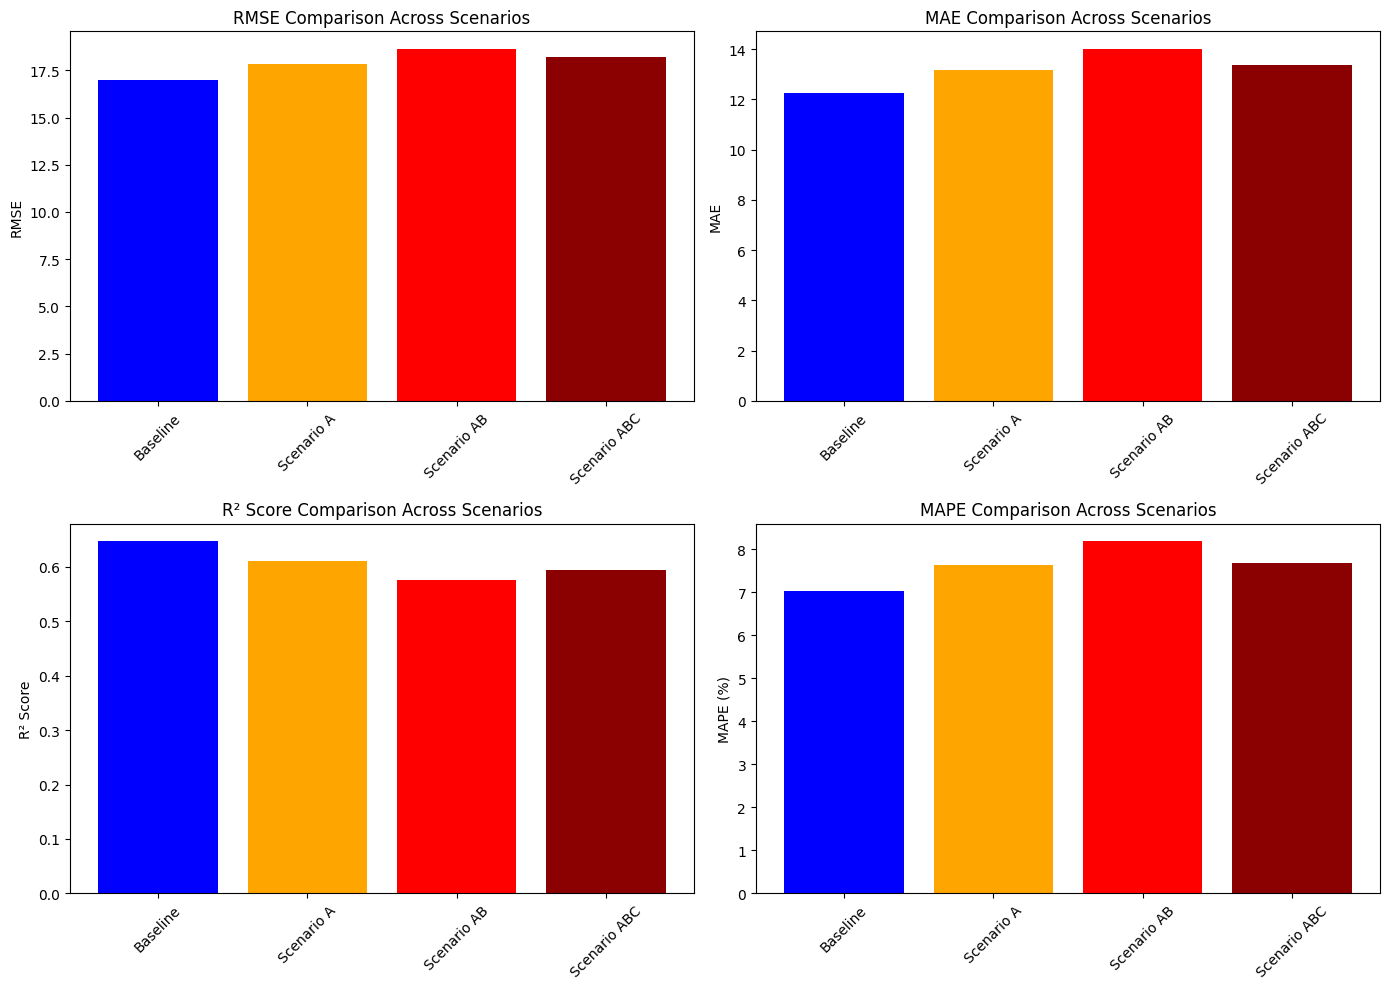

In [15]:
# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

scenarios = comparison_df['Scenario']

# RMSE comparison
axes[0, 0].bar(scenarios, comparison_df['RMSE'], color=['blue', 'orange', 'red', 'darkred'])
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE Comparison Across Scenarios')
axes[0, 0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[0, 1].bar(scenarios, comparison_df['MAE'], color=['blue', 'orange', 'red', 'darkred'])
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('MAE Comparison Across Scenarios')
axes[0, 1].tick_params(axis='x', rotation=45)

# R² comparison
axes[1, 0].bar(scenarios, comparison_df['R²'], color=['blue', 'orange', 'red', 'darkred'])
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('R² Score Comparison Across Scenarios')
axes[1, 0].tick_params(axis='x', rotation=45)

# MAPE comparison
axes[1, 1].bar(scenarios, comparison_df['MAPE (%)'], color=['blue', 'orange', 'red', 'darkred'])
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].set_title('MAPE Comparison Across Scenarios')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [16]:
# Calculate percentage changes from baseline
print("\n" + "="*80)
print("PERFORMANCE DEGRADATION FROM BASELINE")
print("="*80)

baseline_rmse = baseline_metrics['RMSE']
baseline_r2 = baseline_metrics['R2']

for scenario_name in ['Scenario A', 'Scenario AB', 'Scenario ABC']:
    metrics = results_dict[scenario_name]
    rmse = metrics['RMSE']
    r2 = metrics['R2']
    
    rmse_change = ((rmse - baseline_rmse) / baseline_rmse) * 100
    r2_change = ((r2 - baseline_r2) / baseline_r2) * 100
    
    print(f"\n{scenario_name}:")
    print(f"  RMSE change: {rmse_change:+.2f}%")
    print(f"  R² change:   {r2_change:+.2f}%")

print("\n" + "="*80)


PERFORMANCE DEGRADATION FROM BASELINE

Scenario A:
  RMSE change: +4.92%
  R² change:   -5.50%

Scenario AB:
  RMSE change: +9.63%
  R² change:   -11.02%

Scenario ABC:
  RMSE change: +7.11%
  R² change:   -8.04%



## 9. Final Summary

In [19]:
print("\n" + "#"*80)
print("#" + " "*78 + "#")
print("#" + "EXECUTION COMPLETE - ALL DELIVERABLES GENERATED".center(78) + "#")
print("#" + " "*78 + "#")
print("#"*80)

print("\nDELIVERABLES:")
print("\n1. TRAINED MODEL:")
print("   ✓ models/cancer_model.pkl")

print("\n2. PREDICTIONS (CSV):")
print("   ✓ predictions/predictions_scenario_A.csv")
print("   ✓ predictions/predictions_scenario_AB.csv")
print("   ✓ predictions/predictions_scenario_ABC.csv")

print("\n3. EVIDENTLY AI MONITORING REPORTS (HTML):")
print("   ✓ Location: evidently_reports/")
print("   ✓ Data Drift Reports (3 scenarios)")
print("   ✓ Model Performance Reports (3 scenarios)")
print("   ✓ Feature Drift Reports (3 scenarios)")
print("   ✓ Scenario Comparison Table (CSV)")

print("\n4. PERFORMANCE SUMMARY:")
print(f"   Baseline Test Set:")
print(f"     • RMSE: {baseline_metrics['RMSE']:.4f}")
print(f"     • R²:   {baseline_metrics['R2']:.4f}")
print(f"     • MAE:  {baseline_metrics['MAE']:.4f}")

print("\n" + "="*80)
print("To view Evidently AI reports:")
print("1. Navigate to: evidently_reports/")
print("2. Open any .html file in your web browser")
print("3. Explore interactive drift detection and model performance visualizations")
print("="*80)

print("\nSUCCESS: All assignment requirements completed!")
print(f"\nExecution completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


################################################################################
#                                                                              #
#               EXECUTION COMPLETE - ALL DELIVERABLES GENERATED                #
#                                                                              #
################################################################################

DELIVERABLES:

1. TRAINED MODEL:
   ✓ models/cancer_model.pkl

2. PREDICTIONS (CSV):
   ✓ predictions/predictions_scenario_A.csv
   ✓ predictions/predictions_scenario_AB.csv
   ✓ predictions/predictions_scenario_ABC.csv

3. EVIDENTLY AI MONITORING REPORTS (HTML):
   ✓ Location: evidently_reports/
   ✓ Data Drift Reports (3 scenarios)
   ✓ Model Performance Reports (3 scenarios)
   ✓ Feature Drift Reports (3 scenarios)
   ✓ Scenario Comparison Table (CSV)

4. PERFORMANCE SUMMARY:
   Baseline Test Set:
     • RMSE: 16.9972
     • R²:   0.6469
     • MAE:  12.2615

To view Evidently AI rep